# Homework 3


### Luyao Wang

Netid: lw337

In [1]:
import itertools

import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import filters
from skimage.io import imread

plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
%matplotlib inline

## 1) POV-Ray and homography

**(4 points)**

The overall idea of this exercise: First create two different views of a simple scene containing two cubes using POV-ray: 1) from diagonally above, 2) from the side. Then use a homography to convert 1) into a new picture 3), where 3) has the same viewpoint as 2). In order to get the 4 pairs of coordinates for determining the homography, you should use the corners of the sidewall of one cube, these are visible in both views, 1) and 2).

**a)** Use POV-Ray to create two images: Both contain a horizontal plane going through the origin and two cubes with sidelengths 1 each. The first cube has the origin as one of its corners. The second cube has the same orientation as the first cube, their two neighboring facets are separated by 0.5, and they are aligned in a row. Additionally, choose some interesting surface texture for the cubes.

In image 1) the camera is oriented along one of the diagonales (meaning an axis connecting two opposite corners of the cube) of the first cube. Choose the diagonale such that the second cube is partially hidden behind the first cube.

In image 2) the camera view is perpendicular on one of the side facets of the cube such that the second cube is visible next to it.

Load and show the two images in your notebook. For submission of your homework you need to upload also the two pov files. (_2 points_)

**b)** We want to compute a homography that creates another side view from image 1). In order to do so, you need to first determine the coordinates of the side face (which in the second image is facing the camera) in both image 1) and 2). These four pairs of coordinates allow you to compute the homography and then warp the perspective of image 1). (_2 points_)


**ANSWER**


Text(0.5, 1.0, 'From the side')

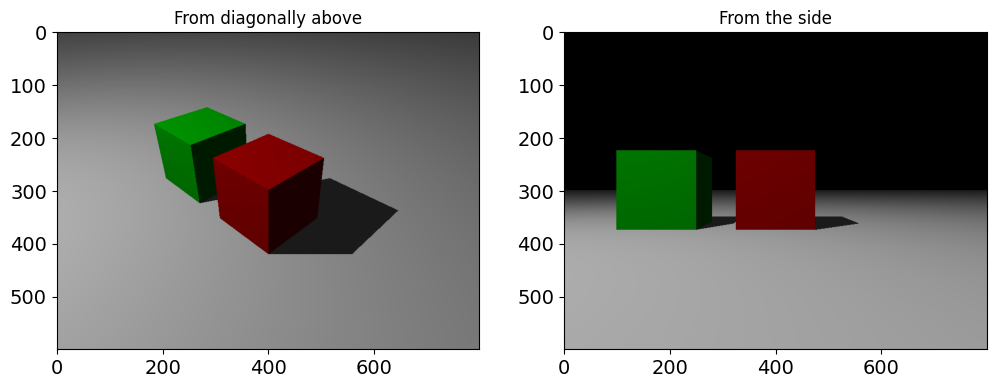

In [2]:
im1 = imread("1.png")
im2 = imread("2.png")

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(im1)
plt.title("From diagonally above")
plt.subplot(122)
plt.imshow(im2)
plt.title("From the side")

In [3]:
im1_coor = np.array([[295, 240], [400, 300], [308, 354], [400, 421]])
im2_coor = np.array([[325, 225], [475, 225], [325, 375], [475, 375]])
h, _ = cv2.findHomography(im1_coor, im2_coor)
h

array([[ 3.83532142e+00, -9.77509751e-01, -3.99465324e+02],
       [-2.97248931e-01,  1.42421997e+00,  9.01963642e+01],
       [ 3.47191180e-03, -2.05791527e-03,  1.00000000e+00]])

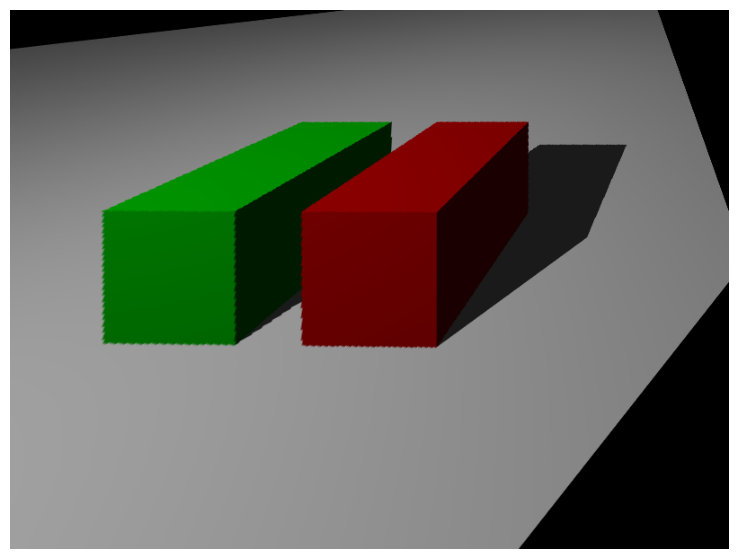

In [4]:
# warp source image
src_temp = cv2.warpPerspective(im1, h, (im2.shape[1], im2.shape[0]))

plt.figure(figsize=(10, 7))
plt.imshow(src_temp)
plt.axis("off")
plt.show()

## 2) Green screen segmentation using HSV

**(2 points)**

Movie productions often happen in front of a green screen. In postproduction the pixels representing the actor are separated by color segmentation (being not green) and copied in front of a different background.

Load a photography of yourself in front of a green screen into this notebook, cut away all potentially distracting areas beyond the boundaries of the green screen and display the result.

Convert the image to HSV plot some percentage of the points in an HSV cube (with the axes H, S, and V) and determine the thresholds to segment the green background. (You can also use the HSV cylinder from the first homework, but determining the thresholds will be easier in the cube). _(1 point)_

Segment the image, then display both the binary mask representing you and the masked original image (i.e. only you standing in front of a black background). Observe that you only need the hue channel for the segmentation. _(1 point)_

(A small reminder: if you want to combine Boolean values, & corresponds to and and | corresponds to or.)


**ANSWER**


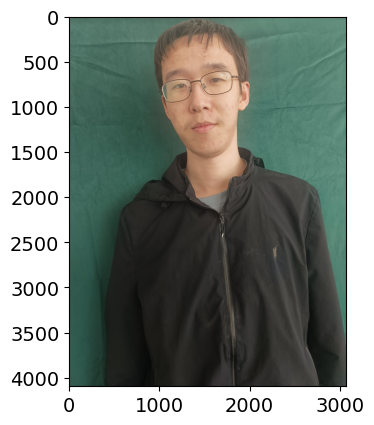

In [5]:
my_photo_raw = imread("my_photo.jpg")
plt.imshow(my_photo_raw)

# 3D plot is run in another notebook


In [6]:
from skimage.color import hsv2rgb, rgb2hsv

myphoto_hsv = rgb2hsv(my_photo_raw)
h = myphoto_hsv[:, :, 0]
s = myphoto_hsv[:, :, 1]
v = myphoto_hsv[:, :, 2]

# import library for 3D plotting
from mpl_toolkits import mplot3d
from matplotlib import colors

# %matplotlib widget

# create list with colors for coloring plot points
img_size = myphoto_hsv.shape[0] * myphoto_hsv.shape[1]
pixel_colors = myphoto_hsv.reshape(img_size, 3)
norm = colors.Normalize()
pixel_colors = norm(pixel_colors).tolist()

# # make an interactive plot
# plt.figure('RGB histogram', figsize=(10,10))
# ax = plt.axes(projection = '3d')

# # plot every 500th pixel (only for performance reasons)
# ax.scatter(h.flatten()[::500],s.flatten()[::500],v.flatten()[::500], c=hsv2rgb(pixel_colors[::500]), marker='.')
# ax.set_xlabel('h')
# ax.set_ylabel('s')
# ax.set_zlabel('v')
# plt.show()

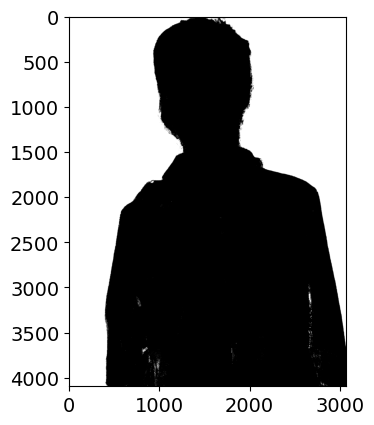

In [7]:
binary_image = (h > 0.15) & (h < 0.5) & (v > 0.0) & (v < 0.65) & (s > 0.22)
plt.imshow(binary_image, cmap=plt.cm.gray)

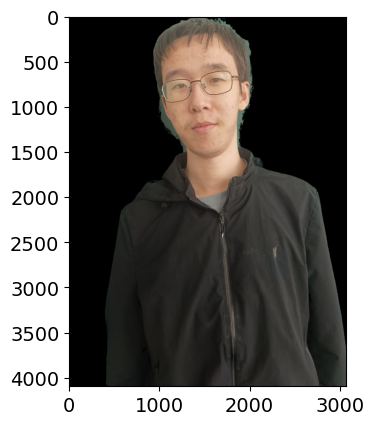

In [8]:
plt.imshow(binary_image, cmap=plt.cm.gray)
myphoto_copy = np.copy(my_photo_raw)
myphoto_copy[binary_image] = 0
plt.imshow(myphoto_copy)

## 3) Rice grains with optimal binarization parameters

**(3 points)**

Load and display the rice.png image.

As you can see the illumination is inhomogeneous which poses a problem for the binarization with a single threshold. As mentioned in the class on segmentation, you can fix this by using a local threshold: for every pixel the average over a square with side length s (in pixels) is computed an then the pixel is binarized with the sum of a) this (local) average and b) a (global) threshold t.

Now we need to determine the optimal parameters for s and t. In a first step we would eyeball a range of reasonable values: compute locally binarized images using all for possible combinations of 201 and 501 for s and -40 and -5 for t. Display that four images. _(0.5 points)_

As you can see, the influence of s is not strong. And while we have many (wrong) inner contours for s = -40, at s=-5 we start to binarize background noise. So these numbers limit a reasonable range for our search.

Now we need a good measure of quality. The number of contours can be a reasonable proxy variable for the quality because both inner boundaries and spurious bachkground pixels will add new wrongful boundaries. So the parameters which give us the minimum count of contours will be the optimum. We could make this argument even more precise by actually counting the number of rice grains by eye and using this number as our target value.

Explore the parameter space by using two nested for-loops: The outer loop goes over filter sizes 201, 351, and 501.
The inner loop goes t values from -40 to -5. Within that inner loop first perform a local binarization with the parameters from the two loops. Then find the contours and compute the number of found objects with len(contours). Save this result in an array. _(1.5point)_

After the nested loops, plot your result with the offset as x-axis and three different curves for the three filter sizes. By choosing the right coordinate ranges you can zoom into the minimum and see which range of the two parameters actually gives an optimal result. _(0.5 points)_

Finally, double check your choice by picking one possible parameter combination and binarizing the image that way. Then find the contours and draw them into the original gray value image. _(0.5 points)_


In [9]:
def apply_local_threshold(image, block_size: int, offset_value: int):
    local_threshold = filters.threshold_local(image, block_size, offset=offset_value)
    thresholded_image = np.where(image > local_threshold, 255, 0)

    return thresholded_image.astype("uint8")

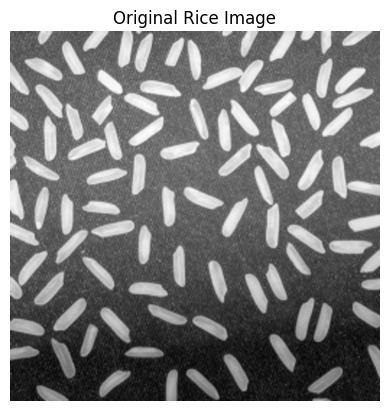

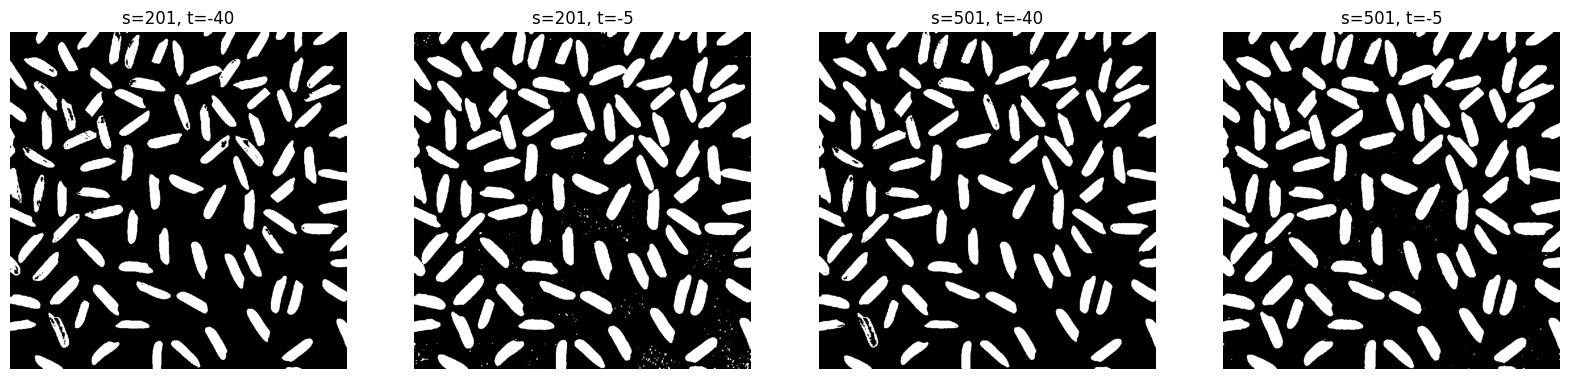

In [10]:
rice_img = imread("rice.png", as_gray=True)

plt.imshow(rice_img, cmap="gray")
plt.axis("off")
plt.title("Original Rice Image")
plt.show()

s_values = [201, 501]
t_values = [-40, -5]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, (s_val, t_val) in enumerate(itertools.product(s_values, t_values)):
    binarized_img = apply_local_threshold(rice_img, s_val, t_val)

    axs[i].imshow(binarized_img, cmap="gray")
    axs[i].set_title(f"s={s_val}, t={t_val}")
    axs[i].axis("off")

plt.show()

In [11]:
s_values = [201, 351, 501]
t_values = list(range(-40, -4))

num_contours = []

for i, (s_val, t_val) in enumerate(itertools.product(s_values, t_values)):
    binarized_img = apply_local_threshold(rice_img, s_val, t_val)
    contours, _ = cv2.findContours(binarized_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    num_contours.append(len(contours))

num_contours = np.array(num_contours)

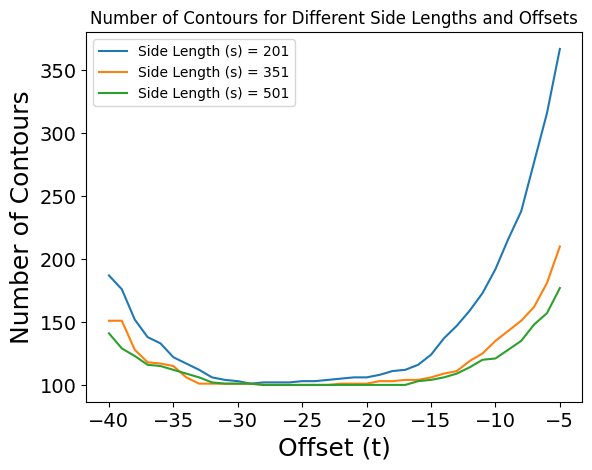

In [12]:
num_contours = num_contours.reshape(len(s_values), len(t_values))

for i, s_val in enumerate(s_values):
    plt.plot(t_values, num_contours[i], label=f"Side Length (s) = {s_val}")

plt.title("Number of Contours for Different Side Lengths and Offsets")
plt.xlabel("Offset (t)")
plt.ylabel("Number of Contours")
plt.legend()

plt.show()

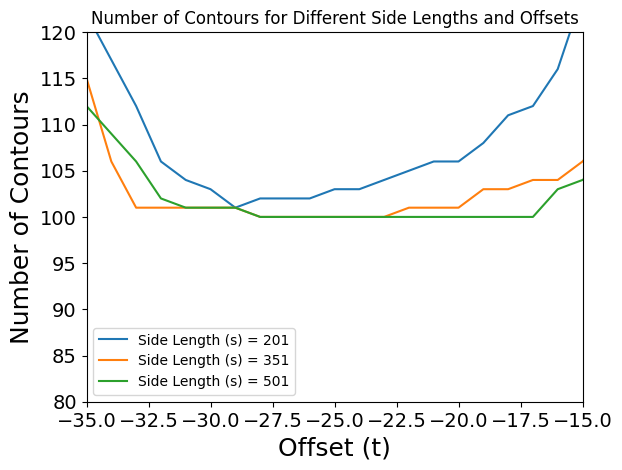

In [17]:
# zoom in to see the details

plt.figure()

for i, s_val in enumerate(s_values):
    plt.plot(t_values, num_contours[i], label=f"Side Length (s) = {s_val}")

plt.title("Number of Contours for Different Side Lengths and Offsets")
plt.xlabel("Offset (t)")
plt.ylabel("Number of Contours")
plt.legend()

plt.xlim(-35, -15)
plt.ylim(80, 120)

plt.show()

Optimal side length: 351, optimal offset: -28, producing 100 contours


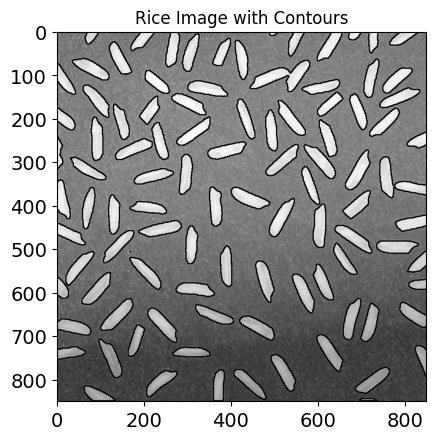

In [18]:
# find index of 2d array
min_index = np.unravel_index(np.argmin(num_contours), num_contours.shape)
s_optimal = s_values[min_index[0]]
t_optimal = t_values[min_index[1]]

print(
    f"Optimal side length: {s_optimal}, optimal offset: {t_optimal}, producing {num_contours[min_index]} contours"
)

binarized_image = apply_local_threshold(rice_img, s_optimal, t_optimal)

contours, _ = cv2.findContours(
    binarized_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

image_with_contours = cv2.drawContours(rice_img.copy(), contours, -1, (0, 255, 0), 2)

plt.imshow(image_with_contours, cmap="gray")
plt.title("Rice Image with Contours")
plt.show()